## 모듈 선언

In [1]:
import os
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

---

## 파일 읽기

### 1) Train Data

#### CSV file read (as DataFrame)

In [2]:
train_data_path ="/aiffel/aiffel/dktc/data/train.csv"
train_data = pd.read_csv(train_data_path)

#### Data Read (with `tail`)

In [3]:
train_data.tail()

,idx,class,conversation
3945,3945,기타 괴롭힘 대화,준하야 넌 대가리가 왜이렇게 크냐?\n내 머리가 뭐.\n밥먹으면 대가리만 크냐 너는...
3946,3946,갈취 대화,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내\n예.?...
3947,3947,직장 내 괴롭힘 대화,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.\n왜 그래. 들리겠어...
3948,3948,갈취 대화,누구맘대로 여기서 장사하래?\n이게 무슨일입니까?\n남의 구역에서 장사하려면 자릿세...
3949,3949,직장 내 괴롭힘 대화,희정씨\n네?\n주말에 시간이 넘쳐나나봐\n갑자기 왜그러세요?\n손이 빤짝빤짝 네일...


---

## 데이터 변환

### 1) 대화 데이터(`conversation`)를 `senteces`에 저장

In [4]:
sentences = [val for val in train_data['conversation']]

In [5]:
# 대화 데이터 개수 파악
len(sentences)

3950

### 2) 대화 분류값(`class`)를 `labels`에 저장

#### `class` 값은 숫자로 변환하여 `labels`에 저장한다
- `협박 관련 대화` &rarr; `0`
- `갈취 관련 대화` &rarr; `1`
- `직장 관련 대화` &rarr; `2`  
- `기타 관련 대화` &rarr; `3`

In [6]:
labels = []

for val in tqdm(train_data['class'], desc="change class value to int num..."):
    if '갈취' in val:
        labels.append(1)
    if '기타' in val:
        labels.append(3)
    if '직장' in val:
        labels.append(2)
    if '협박' in val:
        labels.append(0)

change class value to int num...: 100%|██████████| 3950/3950 [00:00<00:00, 1328269.13it/s]


In [7]:
# labels 개수 파악
len(labels)

3950

#### 3) 사용하지 않는 변수 초기화

In [8]:
del train_data

---

## 모델 학습 준비

### 1) 모델 학습용 파라미터 선언

In [9]:
MAX_LEN = 128
BATCH_SIZE = 16
LEARNING_RATE = 1e-5
EPOCH = 3

### 2) 데이터셋 분할
1. `sentences`와 `labels`를 활용
2. `8:2` 비율로 `train`, `validation` 데이터셋으로 분할

In [10]:
# 데이터셋 분할
train_sentences, val_sentences, train_labels, val_labels = train_test_split(
    sentences, labels, test_size=0.2, random_state=42
)

### 3) 모델 선언
1. 모델: `bert-base-multilingual-cased`
2. BERT 토크나이저 사용

In [11]:
# BERT 토크나이저와 모델 준비
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
model = TFBertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=4)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 4) 데이터(`train`, `validation`)를 BERT 형식으로 변환
1. `예시` &rarr; `[CLS] 안녕하세요 [SEP]`
2. 문장 구분 토큰을 추가하여 Encoding

In [12]:
# 데이터셋을 BERT 입력 형식으로 변환
train_encodings = tokenizer(train_sentences, truncation=True, padding=True, max_length=MAX_LEN)
val_encodings = tokenizer(val_sentences, truncation=True, padding=True, max_length=MAX_LEN)

### 5) Tensor 데이터셋 생성

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).shuffle(100).batch(BATCH_SIZE)

print("Train tensor dataset generated!")

Train tensor dataset generated!


In [14]:
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(BATCH_SIZE)

print("Validation tensor dataset generated!")

Validation tensor dataset generated!


---

## 모델 훈련

### 1) 모델 컴파일

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[ 'accuracy' ])

### 2) 모델 구조 시각화

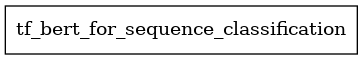

In [16]:
plot_model(model, show_shapes=True, show_layer_names=True)

### 3) 모델 훈련

In [17]:
model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCH)

Epoch 1/3
198/198 [==============================] - 116s 508ms/step - loss: 1.0994 - accuracy: 0.5215 - val_loss: 0.6966 - val_accuracy: 0.7532
Epoch 2/3
198/198 [==============================] - 98s 493ms/step - loss: 0.5830 - accuracy: 0.7924 - val_loss: 0.5299 - val_accuracy: 0.8253
Epoch 3/3
198/198 [==============================] - 98s 493ms/step - loss: 0.4066 - accuracy: 0.8684 - val_loss: 0.5592 - val_accuracy: 0.8203


### 4) 모델 평가

In [18]:
evaluation = model.evaluate(val_dataset)

50/50 [==============================] - 7s 143ms/step - loss: 0.5592 - accuracy: 0.8203


---

## submission.csv 생성해보기

### 1) 파일 읽기 (`test.json`)

In [24]:
test_data_path ="/aiffel/aiffel/dktc/data/test.json"

with open(test_data_path, "r", encoding="utf-8") as json_file:
    test = json.load(json_file)

### 2) 테스트 데이터 읽으면서 예측해보기

In [25]:
test_predicst = list()

for key in test:
    test_sentence = test[key]['text']
    
    test_encodings = tokenizer(test_sentence, truncation=True, padding=True, max_length=128, return_tensors="tf")
    
    test_predictions = model.predict({
        "input_ids": test_encodings["input_ids"],
        "token_type_ids": test_encodings["token_type_ids"],
        "attention_mask": test_encodings["attention_mask"]
    }) # [ 0.7805823,  2.6188664, -2.0281641, -0.9672525]
    test_class_probabilities = tf.nn.softmax(test_predictions.logits, axis=-1).numpy() # [[0.13297564 0.8358507  0.00801584 0.02315779]]
    test_predicted_class = np.argmax(test_class_probabilities, axis=1) # [ 1 ]
    test_predicst.append(test_predicted_class[0])

### 3) `submission.csv` 파일을 위한 `DataFrame` 생성

In [26]:
def labelnum_to_text(x):
    if x == 1 : # 갈취
        return '01'
    if x == 2 : # 직장
        return '02'
    if x == 3 : # 기타
        return '03'
    if x == 0 : # 협박 
        return '00'

submission = pd.DataFrame({'class':test_predicst}, index=list(test.keys()))
submission['class'] = submission['class'].apply(labelnum_to_text)
submission

,class
t_000,01
t_001,02
t_002,02
t_004,03
t_005,03
...,...
t_495,02
t_496,02
t_497,01
t_498,02


### 4) CSV 파일 저장

In [27]:
# 파일명 설정
file_name = "submission_test1_naive.csv"

In [28]:
# 파일 생성
submission.to_csv(file_name)

---

# 테스트 회고

1. `OOM Error`로 인해 `MAX_LEN`를 크게 테스트 해보지 못했다. (ex: `300`)
2. 검증 데이터를 임의로 설정하였다. (`train.csv` 파일로부터)
3. 데이터에 대해 전처리를 하지 않고 모델 실행에만 목적을 두어보았다.
4. 추가로 `model.compile()`에서 Metrics 항목을 추가하려고 했는데 잘못 선언했던것 같다. (현재는 `accuracy`만 설정하여 훈련함)